
# <center> Random Forests Strategy to predict Stock Prices </center>

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
!pip install yfinance
import yfinance as yf
sns.set_theme()

The goal of this project is to implement a Random Forest model for 1 of 10 picked stocks with the rest acting as a reference. For this we start by downloading data from Yahoo Finance. We will develop a Random Forest strategy for trading **AAPL** stock.

In [ ]:
Y = 'AAPL'
equities = [Y, 'AMZN', 'MSFT', 'GOOG', 'TSLA', 'META', 'AMD', 'NVDA', 'GS', 'ADBE']

start_date = "2012-01-01"
end_date = "2016-01-01"

data = yf.download(" ".join(equities), start=start_date, end=end_date)['Adj Close']
data.head()

[*********************100%***********************]  10 of 10 completed


,AAPL,ADBE,AMD,AMZN,GOOG,GS,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2012-01-03,12.519279,28.570000,5.48,8.9515,16.573130,79.779022,NaN,21.466703,3.222134,1.872000
2012-01-04,12.586558,28.280001,5.46,8.8755,16.644611,79.260323,NaN,21.971891,3.258854,1.847333
2012-01-05,12.726295,28.480000,5.46,8.8805,16.413727,79.126465,NaN,22.196423,3.375897,1.808000
2012-01-06,12.859334,28.719999,5.43,9.1305,16.189817,78.156013,NaN,22.541235,3.336883,1.794000
2012-01-09,12.838935,28.530001,5.59,8.9280,15.503389,79.218521,NaN,22.244541,3.336883,1.816667


We'll be working with daily returns of these stocks as our input dataset. We also create the output dataset as the one-day forward returns of **AAPL** stock

In [ ]:
returnsX = (data.shift(-1)/data - 1).fillna(0)
returnsY= returnsX['AAPL'].shift(-1).fillna(0)
returnsX.head()

,AAPL,ADBE,AMD,AMZN,GOOG,GS,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2012-01-03,0.005374,-0.010150,-0.003650,-0.008490,0.004313,-0.006502,0.0,0.023534,0.011396,-0.013177
2012-01-04,0.011102,0.007072,0.000000,0.000563,-0.013871,-0.001689,0.0,0.010219,0.035915,-0.021292
2012-01-05,0.010454,0.008427,-0.005495,0.028152,-0.013642,-0.012265,0.0,0.015535,-0.011557,-0.007743
2012-01-06,-0.001586,-0.006616,0.029466,-0.022178,-0.042399,0.013595,0.0,-0.013162,0.000000,0.012635
2012-01-09,0.003581,0.023484,0.021467,0.004368,0.001092,0.038441,0.0,0.003605,-0.004127,0.013578


The entropy of different one-day lagged stock returns w.r.t current **AAPL** returns are shown below in decreasing order

In [ ]:
entrpy = {}
for stock in equities:
    PYX1 = len(returnsX.loc[(returnsY>0) & (returnsX[stock]>0)]) / len(returnsX[stock]>0)
    PYX2 = len(returnsX.loc[(returnsY>0) & (returnsX[stock]<0)]) / len(returnsX[stock]>0)
    entrpy[stock] = entropy([PYX1, 1-PYX1], base=2) + entropy([PYX2, 1-PYX2], base=2)
entrpy = pd.DataFrame.from_dict(entrpy, orient='index', columns=['Entropy'])
entrpy.sort_values
entrpy.T

,AAPL,AMZN,MSFT,GOOG,TSLA,META,AMD,NVDA,GS,ADBE
Entropy,1.633484,1.63077,1.62117,1.63258,1.631924,1.536938,1.591805,1.616889,1.628118,1.614508


The following plots show the distribution of the forward **AAPL** returns against different current stock price returns. There is very little visible correlation between the **AAPL** one-day lag return and other stock returns

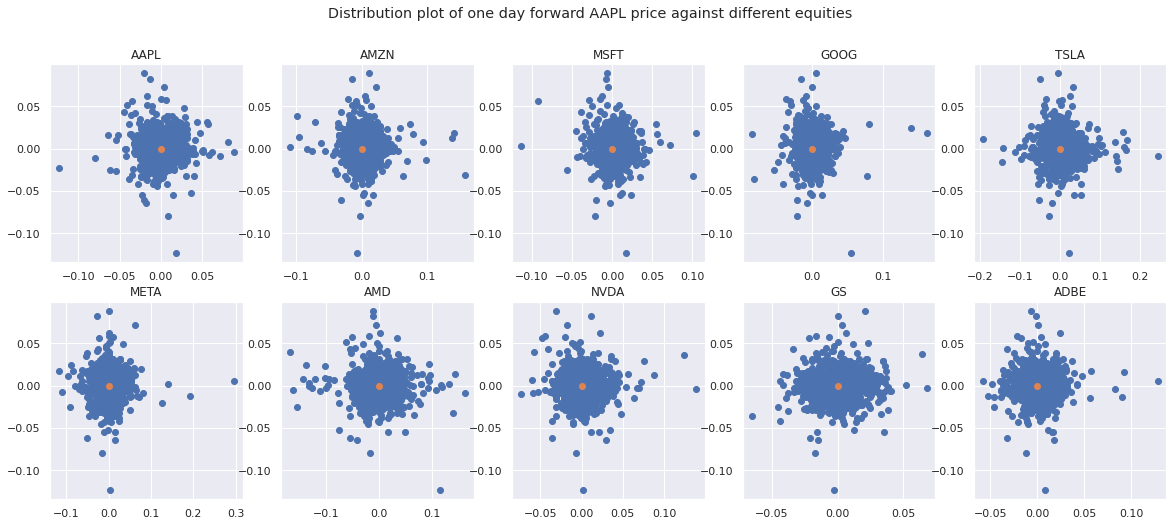

In [ ]:
fig, ax = plt.subplots(2,5,figsize=(20, 8))
fig.suptitle("Distribution plot of one day forward AAPL price against different equities")
for i in range(10):
    row, col = i//5, i%5
    ax[row,col].scatter(returnsX[equities[i]], returnsY)
    ax[row,col].scatter([0], [0])
    ax[row,col].set_title(equities[i])
_ = plt.show()

Let's define few helper functions that will be used by different trading strategies that we will test

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def MAPE(actual, predicted):
    actual, predicted = ((actual>0)-0.5)*2, ((predicted>0)-0.5)*2
    return 100 * np.absolute((predicted - actual) / actual)

def split_train_test_data(returnsX, returnsY, split_frac=0.2):
    splitIdx = int(len(returnsX) * (1 - split_frac))
    return returnsX[:splitIdx], returnsX[splitIdx:], returnsY[:splitIdx], returnsY[splitIdx:]

Methods to train a *Random Forest* model and return the predictions

In [ ]:
def get_rfr_predictions(Xtrain, Ytrain, Xtest, Ytest, n_estimators=100):
    rf = RandomForestRegressor(n_estimators=100, random_state=88)
    rf.fit(Xtrain, Ytrain)
    predictions = rf.predict(Xtest)
    loss = np.mean((predictions - Ytest)**2)
    return rf, loss, predictions

def get_rfc_predictions(Xtrain, Ytrain, Xtest, Ytest, n_estimators=100):
    rf = RandomForestClassifier(n_estimators=100, random_state=88)
    rf.fit(Xtrain, Ytrain)
    predictions = rf.predict(Xtest)
    loss = np.mean((predictions - Ytest)**2)
    return rf, loss, predictions

Helper functions to plot and describe the results from each strategy

In [ ]:
def display_performance(actual, predicted):
    actual, predicted = actual>0, predicted>0
    print('Precision=' + str(round(precision_score(actual, predicted)*100,3)) + '%')
    print('Recall=' + str(round(recall_score(actual, predicted)*100,3)) + '%')
    cf_matrix = confusion_matrix(actual, predicted)
    group_names = ['True -ve', 'False +ve', 'False -ve', 'True +ve']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')
    ax.set(xlabel="Predicted", ylabel="Actual")

In [ ]:
def plot_returns(days, stock_returns, strat_returns):
    plt.figure(figsize=(20,6))
    plt.plot(days, stock_returns-1, label='AAPL')
    plt.plot(days, strat_returns-1, label='RF STRATEGY')

    position = ['HOLD']
    for i in range(1, N):
        if strategy[i-1]!=1 and strategy[i]==1: position.append('BUY')
        elif strategy[i-1]!=-1 and strategy[i]==-1: position.append('SELL')
        else: position.append('HOLD')
    position = np.array(position)
    buys = [stock_returns[position=='BUY']-1, days[position=='BUY']]
    sells = [stock_returns[position=='SELL']-1, days[position=='SELL']]

    plt.scatter(buys[1], buys[0], c='g', marker='.', label='BUY')
    plt.scatter(sells[1], sells[0], c='r', marker='x', label='SELL')
    plt.ylabel('Returns (%)')
    plt.legend()
    return plt

In [ ]:
def describe_returns(days, stock_returns, strat_returns):
    print("Return on AAPL stock = " + str(round(stock_returns[-1]*100-100, 3)) + "%")
    N = len(days)
    print("Annualized return of AAPL stock = " + str(round(np.power(stock_returns[-1], 252/N)*100-100, 3)) + "% p.a.")
    # Print the final and annualized returns for the trading strategy
    print("\nReturn on Random Forest Trading Strategy = " + str(round(strat_returns[-1]*100-100, 3)) + "%")
    print("Annualized return generated by the above strategy = " + str(round(np.power(strat_returns[-1], 252/N)*100-100, 3)) + "% p.a.")
    # Print the final and annualized returns for the leveraged trading strategy

In [ ]:
def feature_importance(rf):
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(equities, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances
    [print('Stock: {:10} Importance: {}'.format(*pair)) for pair in feature_importances];

Let's split the data into 80% training and 20% testing datasets

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = split_train_test_data(returnsX, returnsY, 0.2)

**Random Forest Regressor:**

We then run a *Random Forest Regressor* with *1000* trees to predict the next day return of **AAPL** stock

In [ ]:
rfr, loss, predictions = get_rfr_predictions(Xtrain, Ytrain, Xtest, Ytest, n_estimators=1000)
print("Random Forest Regressor:")
print(feature_importance(rfr))

Random Forest Regressor:
Stock: TSLA       Importance: 0.15
Stock: AAPL       Importance: 0.11
Stock: META       Importance: 0.11
Stock: AMZN       Importance: 0.1
Stock: GS         Importance: 0.1
Stock: AMD        Importance: 0.09
Stock: NVDA       Importance: 0.09
Stock: ADBE       Importance: 0.09
Stock: MSFT       Importance: 0.08
Stock: GOOG       Importance: 0.08
None


We *BUY / LONG* the stock if the predicted return is greater than **2.5%**. Instead, we *SELL / SHORT* the stock if the predicted return is less than **-2.5%**

In [ ]:
def get_regression_strategy(predictions):
    strategy = np.zeros_like(predictions)
    strategy[predictions > 0.0025] = 1
    strategy[predictions < -0.0025] = -1
    return strategy

In [ ]:
N = len(predictions)
mape = MAPE(Ytest, predictions)
print("MAPE for this period: " + str(round(np.mean(mape), 3)) + '%')
print("Accuracy for this period: " + str(round(np.mean(Ytest*predictions >= 0)*100, 3)) + '%')

strategy = get_regression_strategy(predictions)
stock_returns = (1 + Ytest).cumprod()
strat_returns_rfr = (1 + strategy * Ytest).cumprod()
days = returnsY.index[-N:]

MAPE for this period: 103.96%
Accuracy for this period: 49.01%


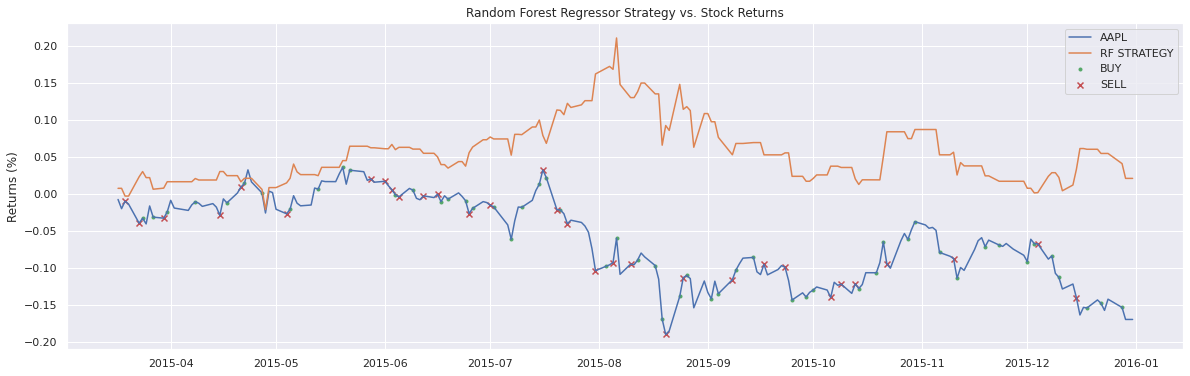

In [ ]:
plt = plot_returns(days, stock_returns, strat_returns_rfr)
_ = plt.title('Random Forest Regressor Strategy vs. Stock Returns')

In [ ]:
describe_returns(days, stock_returns, strat_returns_rfr)

Return on AAPL stock = -16.998%
Annualized return of AAPL stock = -20.739% p.a.

Return on Random Forest Trading Strategy = 2.101%
Annualized return generated by the above strategy = 2.628% p.a.


Precision=43.077%
Recall=64.368%


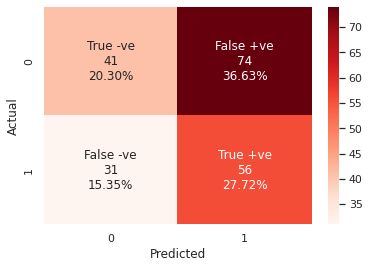

In [ ]:
display_performance(Ytest, predictions)

**Random Forest Classifier:**

We run a *Random Forest Classifier* model on the same datasets

In [ ]:
rfc, loss, predictions = get_rfc_predictions(Xtrain, np.array(Ytrain>=0, dtype=int), Xtest, np.array(Ytest>=0, dtype=int), n_estimators=1000)
print("Random Forest Classifier:")
print(feature_importance(rfc))

Random Forest Classifier:
Stock: AMZN       Importance: 0.11
Stock: TSLA       Importance: 0.11
Stock: AAPL       Importance: 0.1
Stock: GOOG       Importance: 0.1
Stock: META       Importance: 0.1
Stock: AMD        Importance: 0.1
Stock: NVDA       Importance: 0.1
Stock: ADBE       Importance: 0.1
Stock: MSFT       Importance: 0.09
Stock: GS         Importance: 0.09
None


Here our strategy is to *BUY / LONG* the **AAPL** stock when the classifier predicts that the next day price is moving up, and *SELL / SHORT* the stock when the classifier predicts the next day price is moving down.

In [ ]:
def get_classifier_strategy(predictions):
    return np.array((predictions-0.5)*2, dtype=int)

In [ ]:
N = len(predictions)
mape = MAPE(np.array(Ytest>=0, dtype=int), predictions)
print("MAPE for this period: " + str(round(np.mean(mape), 3)) + '%')
print("Accuracy for this period: " + str(round(np.mean(Ytest*predictions >= 0)*100, 3)) + '%')

strategy = get_classifier_strategy(predictions)
stock_returns = (1 + Ytest).cumprod()
strat_returns_rfc = (1 + strategy * Ytest).cumprod()
days = returnsY.index[-N:]

MAPE for this period: 96.04%
Accuracy for this period: 65.347%


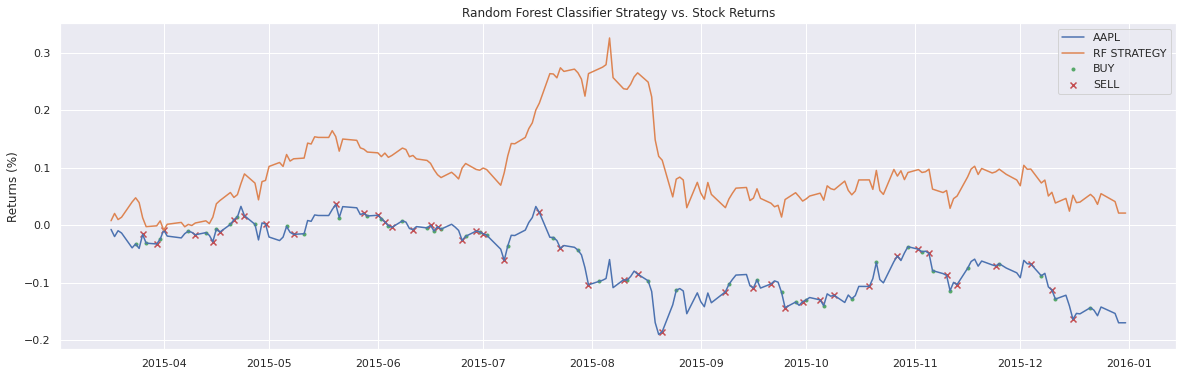

In [ ]:
plt = plot_returns(days, stock_returns, strat_returns_rfc)
_ = plt.title('Random Forest Classifier Strategy vs. Stock Returns')

In [ ]:
describe_returns(days, stock_returns, strat_returns_rfc)

Return on AAPL stock = -16.998%
Annualized return of AAPL stock = -20.739% p.a.

Return on Random Forest Trading Strategy = 2.088%
Annualized return generated by the above strategy = 2.611% p.a.


Precision=45.455%
Recall=68.966%


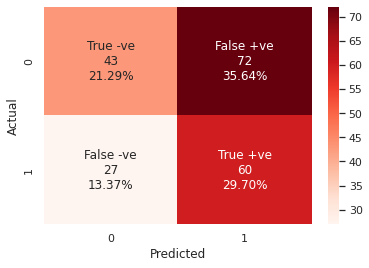

In [ ]:
display_performance(Ytest, predictions)

**Rolling Window Strategy:**



The previous strategies use a static classifier, which is once trained on historical data, then used for all future dates. However, stock price data can be highly unpredictable, and one needs to frequently update their model to remain competitive. Botj the static **Classifier** and **Regressor** models have very poor *accuracy*, *precision* and *recall* scores.

To overcome this issue, we use the **Rolling Window Strategy**. This strategy builds a new *Random Forest Classifier* for each window of trading days. For each window, the training dataset is a fixed number of past days immediately before the start of the window. Once a model is formed, it is used to get the predictions for only the dates in the current window. This way the strategy can adapt to any fundamental changes in the market. We have used a window of *40* trading days, roughly two month of actual days.

In [ ]:
# trainData:testData :: 19:1
split_ratio = 19
window = 40

predictions, stock = [], []
for i in range(split_ratio*window, len(returnsX)-window-1, window):
    # Get the training and testing data for the window
    split_frac = 1.0 / (1.0 + split_ratio)
    start, end = i-split_ratio*window, i+window
    Xwindow, Ywindow = returnsX[start:end], returnsY[start:end]
    Xtrain, Xtest, Ytrain, Ytest = split_train_test_data(Xwindow, Ywindow, split_frac)

    # Instantiate and train model with 1000 decision trees
    _, _, pred = get_rfc_predictions(Xtrain, np.array(Ytrain>=0, dtype=int), Xtest, np.array(Ytest>=0, dtype=int), 1000)
    predictions.extend(pred)
    stock.extend(Ytest.values)

predictions, stock, = np.array(predictions), np.array(stock)

In [ ]:
N = len(predictions)
mape = MAPE(stock, predictions)
print("MAPE for this period:" + str(round(np.mean(mape), 3)) + '%')
print("Accuracy for this period:" + str(round(np.mean(stock*predictions >= 0)*100, 3)) + '%')

strategy = get_classifier_strategy(predictions)
stock_returns = (1 + stock).cumprod()
strat_returns_rw = (1 + strategy * stock).cumprod()
days = returnsY.index[-N:]

MAPE for this period:96.667%
Accuracy for this period:72.5%


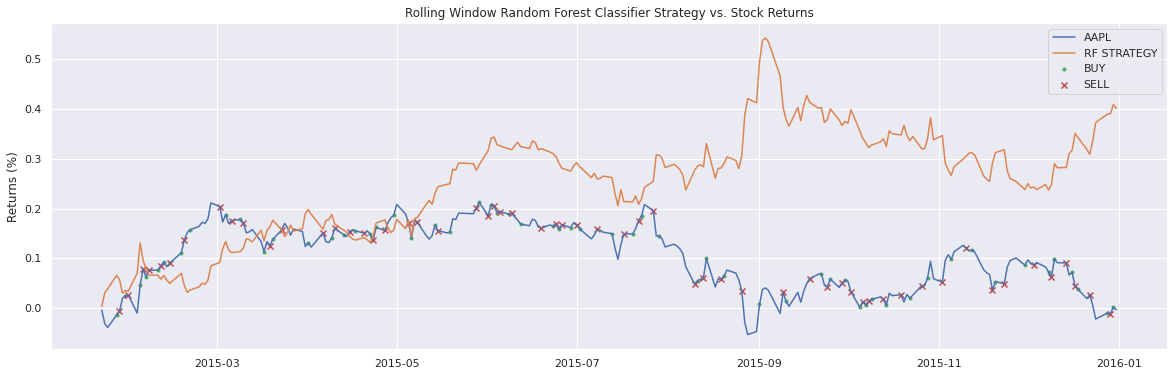

In [ ]:
plt = plot_returns(days, stock_returns, strat_returns_rw)
_ = plt.title('Rolling Window Random Forest Classifier Strategy vs. Stock Returns')

In [ ]:
describe_returns(days, stock_returns, strat_returns_rw)

Return on AAPL stock = -0.317%
Annualized return of AAPL stock = -0.333% p.a.

Return on Random Forest Trading Strategy = 40.088%
Annualized return generated by the above strategy = 42.469% p.a.


Precision=49.618%
Recall=56.522%


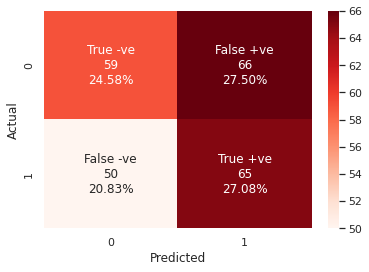

In [ ]:
display_performance(stock, predictions)

Results of all three strategies

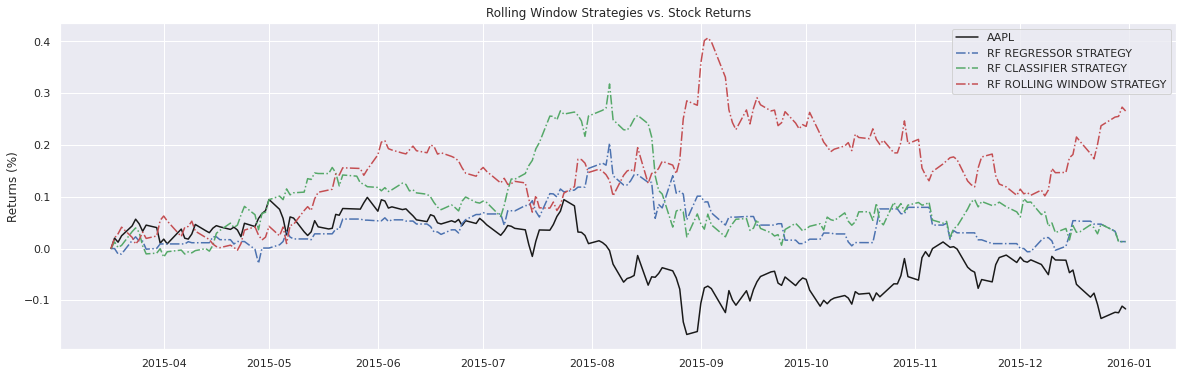

In [ ]:
plt.figure(figsize=(20,6))
N = min(len(days), len(stock_returns), len(strat_returns_rfr), len(strat_returns_rfc), len(strat_returns_rw))
plt.plot(days[-N:], stock_returns[-N:]-stock_returns[-N], 'k', label='AAPL')
plt.plot(days[-N:], strat_returns_rfr[-N:]-strat_returns_rfr[-N], 'b-.', label='RF REGRESSOR STRATEGY')
plt.plot(days[-N:], strat_returns_rfc[-N:]-strat_returns_rfc[-N], 'g-.', label='RF CLASSIFIER STRATEGY')
plt.plot(days[-N:], strat_returns_rw[-N:]-strat_returns_rw[-N], 'r-.', label='RF ROLLING WINDOW STRATEGY')
plt.legend()
plt.ylabel('Returns (%)')
_ = plt.title('Rolling Window Strategies vs. Stock Returns')

Comparing all three strategies, we can see that the **Rolling Window Random Forest Classifier** strategy outperms the other two strategies most of the time. This strategy gives an annual return of **41%**, which is better than the **Bayesian Learning Strategy**, which only gave **30%**. The vanilla Random Forest Regressor and Classifier models performed poorly with annual returns of only **5.5%** and **8.4%** respectively.